In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)
size = 3
pre_smoothing = False
conv = True
sigma = 0.5


import logging
tf.get_logger().setLevel(logging.ERROR)

2023-02-18 16:37:18.514585: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-18 16:37:19.062218: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-02-18 16:37:19.062262: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64

## Data augmentation

In [2]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=30,var1_u=60,CROP1=CROP,BATCH_SIZE=50)

2023-02-18 16:37:19.818321: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-18 16:37:19.818537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-18 16:37:19.845043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-18 16:37:19.845275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-18 16:37:19.845454: I tensorflow/compiler/xla/stream_executo

In [3]:
xs, ys = next(gen_batch_val.as_numpy_iterator())

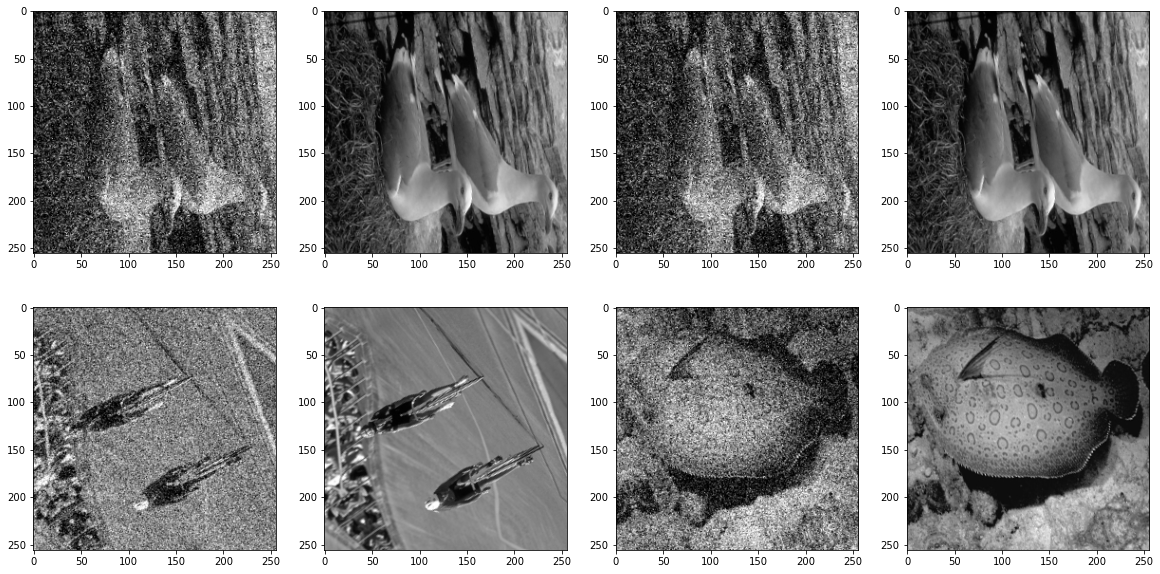

In [4]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs))
        axs[i,2*j].imshow(np.squeeze(xs[_]),cmap='gray')
        axs[i,2*j+1].imshow(np.squeeze(ys[_]),cmap='gray')
        #axs[i,2*j].set_title(str(np.mean(xs[_])))
        
plt.show()

# Neural networks

In [5]:
strategy = tf.distribute.MirroredStrategy()
#strategy = tf.distribute.OneDeviceStrategy('/device:GPU:0')

## Training

In [5]:
def loss(y_true,y_pred):
    error = tf.maximum(0.,1/tf.image.psnr(y_true,y_pred,1))
    error += (1-tf.image.ssim(y_true,y_pred,1))
    error += tf.maximum(0.,tf.math.log(tf.keras.losses.MeanSquaredError()(y_true,y_pred)))
    return error

In [ ]:
typ = "gaussian"
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=5,var1_u=55,CROP1=CROP,BATCH_SIZE=100,training=False)

order = 1
for num_classes in [5,10,15,20,50]:
    print('num_classes: ',num_classes)
    H = []
    model = get_model("splines",it_lim=3,image_size=image_size,num_classes=num_classes,order=order)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss=loss,)
    #model.load_weights(f"./checkpoints/splines_{typ}_{num_classes}")

    

    epochs = 10
    probs = (np.linspace(0,1,epochs)**2)/3
    for it in range(epochs):
        print(it)

        X,Y = [],[]

        iterations = 10

        for i in range(iterations):
            xs, ys = next(gen_batch_train.as_numpy_iterator())

            r = np.random.uniform(0,1)
            if r > probs[it]:
                X.append(xs)
            else:
                X.append(model(xs))
            Y.append(ys)

        X = np.concatenate(X)
        Y = np.concatenate(Y)

        X_val,Y_val = [],[]

        xs, ys = next(gen_batch_val.as_numpy_iterator())
        X_val.append(xs)
        Y_val.append(ys)
        xs, ys = next(gen_batch_val.as_numpy_iterator())
        X_val.append(xs)
        Y_val.append(ys)
        
        xs, ys = next(gen_batch_val.as_numpy_iterator())
        if it > epochs//2:
            X_val.append(model(xs))
        else:
            X_val.append(xs)
        Y_val.append(ys)
        xs, ys = next(gen_batch_val.as_numpy_iterator())
        if it > epochs//2:
            X_val.append(model(xs))
        else:
            X_val.append(xs)
        Y_val.append(ys)
            


        X_val = np.concatenate(X_val)
        Y_val = np.concatenate(Y_val)

        while True:
            
            callbacks = [tf.keras.callbacks.ModelCheckpoint(
                        filepath= f"./checkpoints/splines_{typ}_{num_classes}",
                        save_weights_only=True,
                        verbose = True,
                        save_best_only=True),
                                    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1),
                                    tf.keras.callbacks.TerminateOnNaN()

                        ]

            history = model.fit(X,Y,
                epochs=50,
                validation_data=(X_val,Y_val),
                shuffle=False,
                use_multiprocessing=True,
                callbacks=callbacks,
                workers=1
            )

            

            if not np.isnan(history.history['val_loss'][-1]):
                H.append(history.history)
                break

        
            

    
    loss_ar = np.concatenate([i['loss'] for i in H])
    val_loss = np.concatenate([i['val_loss'] for i in H])

    #np.save(f'./history/splines_{typ}_{num_classes}.npy',np.array([history.history['loss'],history.history['val_loss']]))
    np.save(f'./history/splines_{typ}_{num_classes}.npy', np.array([loss_ar,val_loss]))


In [ ]:
typ = "gaussian"
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=5,var1_u=55,CROP1=CROP,BATCH_SIZE=100,training=False)

order = 1
for num_classes in [5,10,15,20,50]:
    print('num_classes: ',num_classes)
    H = []
    model = get_model("decreasing_taylor",it_lim=3,image_size=image_size,num_classes = num_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss=loss,)
    #model.load_weights(f"./checkpoints/splines_{typ}_{num_classes}")

    

    epochs = 20
    probs = (np.linspace(0,1,epochs)**2)/3
    for it in range(epochs):
        print(it)

        X,Y = [],[]

        iterations = 10

        for i in range(iterations):
            xs, ys = next(gen_batch_train.as_numpy_iterator())

            r = np.random.uniform(0,1)
            if r > probs[it]:
                X.append(xs)
            else:
                X.append(model(xs))
            Y.append(ys)

        X = np.concatenate(X)
        Y = np.concatenate(Y)

        X_val,Y_val = [],[]

        xs, ys = next(gen_batch_val.as_numpy_iterator())
        X_val.append(xs)
        Y_val.append(ys)
        xs, ys = next(gen_batch_val.as_numpy_iterator())
        X_val.append(xs)
        Y_val.append(ys)
        
        xs, ys = next(gen_batch_val.as_numpy_iterator())
        if it > epochs//2:
            X_val.append(model(xs))
        else:
            X_val.append(xs)
        Y_val.append(ys)
        xs, ys = next(gen_batch_val.as_numpy_iterator())
        if it > epochs//2:
            X_val.append(model(xs))
        else:
            X_val.append(xs)
        Y_val.append(ys)
            


        X_val = np.concatenate(X_val)
        Y_val = np.concatenate(Y_val)

        while True:
            
            callbacks = [tf.keras.callbacks.ModelCheckpoint(
                        filepath= f"../decreasing/checkpoints/dectaylor_{typ}_{num_classes}",
                        save_weights_only=True,
                        verbose = True,
                        save_best_only=True),
                                    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1),
                                    tf.keras.callbacks.TerminateOnNaN()

                        ]

            history = model.fit(X,Y,
                epochs=50,
                validation_data=(X_val,Y_val),
                shuffle=False,
                use_multiprocessing=True,
                callbacks=callbacks,
                workers=1
            )

            

            if not np.isnan(history.history['val_loss'][-1]):
                H.append(history.history)
                break

        
            

    
    loss_ar = np.concatenate([i['loss'] for i in H])
    val_loss = np.concatenate([i['val_loss'] for i in H])

    #np.save(f'./history/splines_{typ}_{num_classes}.npy',np.array([history.history['loss'],history.history['val_loss']]))
    np.save(f'../decreasing/history/dectaylor_{typ}_{num_classes}.npy', np.array([loss_ar,val_loss]))
    
    
    

num_classes:  5
0
Epoch 1/50


2023-02-18 16:37:56.055928: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8302
2023-02-18 16:37:57.086901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-18 16:37:57.226716: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x557b37e2c230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-18 16:37:57.226743: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2023-02-18 16:37:57.226747: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
2023-02-18 16:37:57.230015: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-18 16:37:57.30819

32/32 [==============================] - ETA: 0s - loss: 0.7745
Epoch 1: val_loss improved from inf to 0.57540, saving model to ../decreasing/checkpoints/dectaylor_gaussian_5
32/32 [==============================] - 13s 102ms/step - loss: 0.7745 - val_loss: 0.5754 - lr: 1.0000e-04
Epoch 2/50
31/32 [============================>.] - ETA: 0s - loss: 0.6806
Epoch 2: val_loss did not improve from 0.57540
32/32 [==============================] - 2s 63ms/step - loss: 0.6809 - val_loss: 0.5948 - lr: 1.0000e-04
Epoch 3/50
31/32 [============================>.] - ETA: 0s - loss: 0.5845
Epoch 3: val_loss improved from 0.57540 to 0.56350, saving model to ../decreasing/checkpoints/dectaylor_gaussian_5
32/32 [==============================] - 2s 68ms/step - loss: 0.5854 - val_loss: 0.5635 - lr: 1.0000e-04
Epoch 4/50
31/32 [============================>.] - ETA: 0s - loss: 0.5245
Epoch 4: val_loss improved from 0.56350 to 0.52988, saving model to ../decreasing/checkpoints/dectaylor_gaussian_5
32/32 

Epoch 33/50
31/32 [============================>.] - ETA: 0s - loss: 0.3583
Epoch 33: val_loss did not improve from 0.35776
32/32 [==============================] - 2s 63ms/step - loss: 0.3585 - val_loss: 0.3716 - lr: 2.0000e-05
Epoch 34/50
31/32 [============================>.] - ETA: 0s - loss: 0.3581
Epoch 34: val_loss did not improve from 0.35776

Epoch 34: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
32/32 [==============================] - 2s 64ms/step - loss: 0.3583 - val_loss: 0.3717 - lr: 2.0000e-05
Epoch 35/50
31/32 [============================>.] - ETA: 0s - loss: 0.3580
Epoch 35: val_loss did not improve from 0.35776
32/32 [==============================] - 2s 64ms/step - loss: 0.3582 - val_loss: 0.3715 - lr: 4.0000e-06
Epoch 36/50
31/32 [============================>.] - ETA: 0s - loss: 0.3579
Epoch 36: val_loss did not improve from 0.35776
32/32 [==============================] - 2s 64ms/step - loss: 0.3581 - val_loss: 0.3717 - lr: 4.0000e-06
Epoch 

31/32 [============================>.] - ETA: 0s - loss: 0.3645
Epoch 14: val_loss improved from 0.36549 to 0.36546, saving model to ../decreasing/checkpoints/dectaylor_gaussian_5
32/32 [==============================] - 2s 70ms/step - loss: 0.3641 - val_loss: 0.3655 - lr: 8.0000e-07
Epoch 15/50
31/32 [============================>.] - ETA: 0s - loss: 0.3645
Epoch 15: val_loss improved from 0.36546 to 0.36542, saving model to ../decreasing/checkpoints/dectaylor_gaussian_5
32/32 [==============================] - 2s 69ms/step - loss: 0.3641 - val_loss: 0.3654 - lr: 8.0000e-07
Epoch 16/50
31/32 [============================>.] - ETA: 0s - loss: 0.3644
Epoch 16: val_loss improved from 0.36542 to 0.36537, saving model to ../decreasing/checkpoints/dectaylor_gaussian_5
32/32 [==============================] - 2s 70ms/step - loss: 0.3640 - val_loss: 0.3654 - lr: 8.0000e-07
Epoch 17/50
31/32 [============================>.] - ETA: 0s - loss: 0.3644
Epoch 17: val_loss improved from 0.36537 to 0

32/32 [==============================] - 2s 69ms/step - loss: 0.3629 - val_loss: 0.3645 - lr: 8.0000e-07
Epoch 42/50
31/32 [============================>.] - ETA: 0s - loss: 0.3632
Epoch 42: val_loss improved from 0.36451 to 0.36447, saving model to ../decreasing/checkpoints/dectaylor_gaussian_5
32/32 [==============================] - 2s 70ms/step - loss: 0.3628 - val_loss: 0.3645 - lr: 8.0000e-07
Epoch 43/50
31/32 [============================>.] - ETA: 0s - loss: 0.3632
Epoch 43: val_loss improved from 0.36447 to 0.36444, saving model to ../decreasing/checkpoints/dectaylor_gaussian_5
32/32 [==============================] - 2s 70ms/step - loss: 0.3628 - val_loss: 0.3644 - lr: 8.0000e-07
Epoch 44/50
31/32 [============================>.] - ETA: 0s - loss: 0.3631
Epoch 44: val_loss improved from 0.36444 to 0.36441, saving model to ../decreasing/checkpoints/dectaylor_gaussian_5
32/32 [==============================] - 2s 70ms/step - loss: 0.3627 - val_loss: 0.3644 - lr: 8.0000e-07
Epoc

32/32 [==============================] - 2s 70ms/step - loss: 0.3625 - val_loss: 0.3501 - lr: 8.0000e-07
Epoch 20/50
31/32 [============================>.] - ETA: 0s - loss: 0.3628
Epoch 20: val_loss improved from 0.35011 to 0.35006, saving model to ../decreasing/checkpoints/dectaylor_gaussian_5
32/32 [==============================] - 2s 70ms/step - loss: 0.3624 - val_loss: 0.3501 - lr: 8.0000e-07
Epoch 21/50
31/32 [============================>.] - ETA: 0s - loss: 0.3627
Epoch 21: val_loss improved from 0.35006 to 0.35000, saving model to ../decreasing/checkpoints/dectaylor_gaussian_5
32/32 [==============================] - 2s 70ms/step - loss: 0.3623 - val_loss: 0.3500 - lr: 8.0000e-07
Epoch 22/50
31/32 [============================>.] - ETA: 0s - loss: 0.3626
Epoch 22: val_loss improved from 0.35000 to 0.34995, saving model to ../decreasing/checkpoints/dectaylor_gaussian_5
32/32 [==============================] - 2s 70ms/step - loss: 0.3622 - val_loss: 0.3499 - lr: 8.0000e-07
Epoc

31/32 [============================>.] - ETA: 0s - loss: 0.3602
Epoch 47: val_loss improved from 0.34881 to 0.34877, saving model to ../decreasing/checkpoints/dectaylor_gaussian_5
32/32 [==============================] - 2s 70ms/step - loss: 0.3598 - val_loss: 0.3488 - lr: 8.0000e-07
Epoch 48/50
31/32 [============================>.] - ETA: 0s - loss: 0.3601
Epoch 48: val_loss improved from 0.34877 to 0.34872, saving model to ../decreasing/checkpoints/dectaylor_gaussian_5
32/32 [==============================] - 2s 71ms/step - loss: 0.3597 - val_loss: 0.3487 - lr: 8.0000e-07
Epoch 49/50
31/32 [============================>.] - ETA: 0s - loss: 0.3600
Epoch 49: val_loss improved from 0.34872 to 0.34868, saving model to ../decreasing/checkpoints/dectaylor_gaussian_5
32/32 [==============================] - 2s 70ms/step - loss: 0.3596 - val_loss: 0.3487 - lr: 8.0000e-07
Epoch 50/50
31/32 [============================>.] - ETA: 0s - loss: 0.3599
Epoch 50: val_loss improved from 0.34868 to 0

In [ ]:
typ = "gaussian"
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=5,var1_u=55,CROP1=CROP,BATCH_SIZE=100,training=False)

order = 1
for num_classes in [50]:
    print('num_classes: ',num_classes)
    H = []
    model = get_model("decreasing_linear",it_lim=3,image_size=image_size,num_classes = num_classes,order=order)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss=loss,)
    #model.load_weights(f"./checkpoints/splines_{typ}_{num_classes}")

    

    epochs = 20
    probs = (np.linspace(0,1,epochs)**2)/3
    for it in range(epochs):
        print(it)

        X,Y = [],[]

        iterations = 10

        for i in range(iterations):
            xs, ys = next(gen_batch_train.as_numpy_iterator())

            r = np.random.uniform(0,1)
            if r > probs[it]:
                X.append(xs)
            else:
                X.append(model(xs))
            Y.append(ys)

        X = np.concatenate(X)
        Y = np.concatenate(Y)

        X_val,Y_val = [],[]

        xs, ys = next(gen_batch_val.as_numpy_iterator())
        X_val.append(xs)
        Y_val.append(ys)
        xs, ys = next(gen_batch_val.as_numpy_iterator())
        X_val.append(xs)
        Y_val.append(ys)
        
        xs, ys = next(gen_batch_val.as_numpy_iterator())
        if it > epochs//2:
            X_val.append(model(xs))
        else:
            X_val.append(xs)
        Y_val.append(ys)
        xs, ys = next(gen_batch_val.as_numpy_iterator())
        if it > epochs//2:
            X_val.append(model(xs))
        else:
            X_val.append(xs)
        Y_val.append(ys)
            


        X_val = np.concatenate(X_val)
        Y_val = np.concatenate(Y_val)

        while True:
            
            callbacks = [tf.keras.callbacks.ModelCheckpoint(
                        filepath= f"../decreasing/checkpoints/declinear_{typ}_{num_classes}",
                        save_weights_only=True,
                        verbose = True,
                        save_best_only=True),
                                    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1),
                                    tf.keras.callbacks.TerminateOnNaN(),
                        ]

            history = model.fit(X,Y,
                epochs=50,
                validation_data=(X_val,Y_val),
                shuffle=False,
                use_multiprocessing=True,
                callbacks=callbacks,
                workers=1
            )

            

            if not np.isnan(history.history['val_loss'][-1]):
                H.append(history.history)
                break

        
            

    
    loss_ar = np.concatenate([i['loss'] for i in H])
    val_loss = np.concatenate([i['val_loss'] for i in H])

    #np.save(f'./history/splines_{typ}_{num_classes}.npy',np.array([history.history['loss'],history.history['val_loss']]))
    np.save(f'../decreasing/history/declinear_{typ}_{num_classes}.npy', np.array([loss_ar,val_loss]))

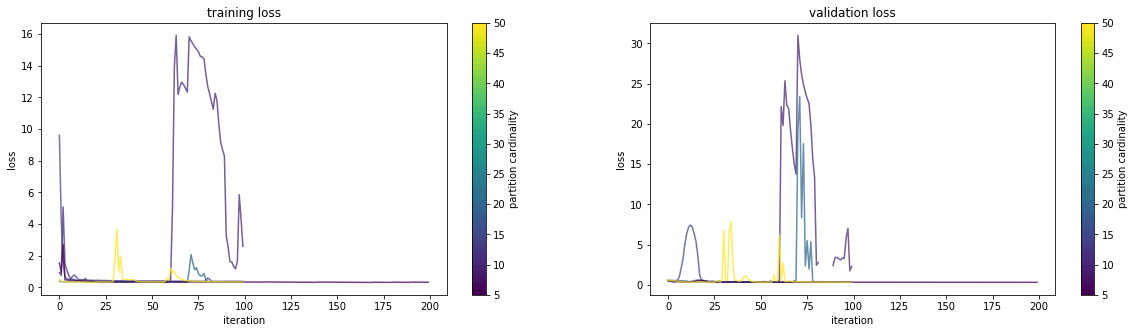

In [49]:
trained = glob(f'./history/splines_*')
w = [int(i.split('_')[-1].split('.')[0]) for i in trained]
n = len(trained)+1
viridis = cm.get_cmap('viridis', 256)
colors = viridis(np.linspace(0, 1, np.amax(w)-np.amin(w)+1))
newcmp = ListedColormap(colors)
norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))

fig,axs = plt.subplots(ncols=2,figsize=(20,5))

for j,i in enumerate(trained):
    
    v = np.load(i)
    axs[0].plot(v[0],alpha=0.75,color = colors[w[j]-np.amin(w)])
    axs[1].plot(v[1],alpha=0.75,color = colors[w[j]-np.amin(w)])
    
axs[0].set_title("training loss")
axs[1].set_title("validation loss")


axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')

axs[1].set_xlabel('iteration')
axs[1].set_ylabel('loss')
    
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[0],label='partition cardinality')
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[1],label='partition cardinality')

    
plt.show()



# Results

# Results with first function

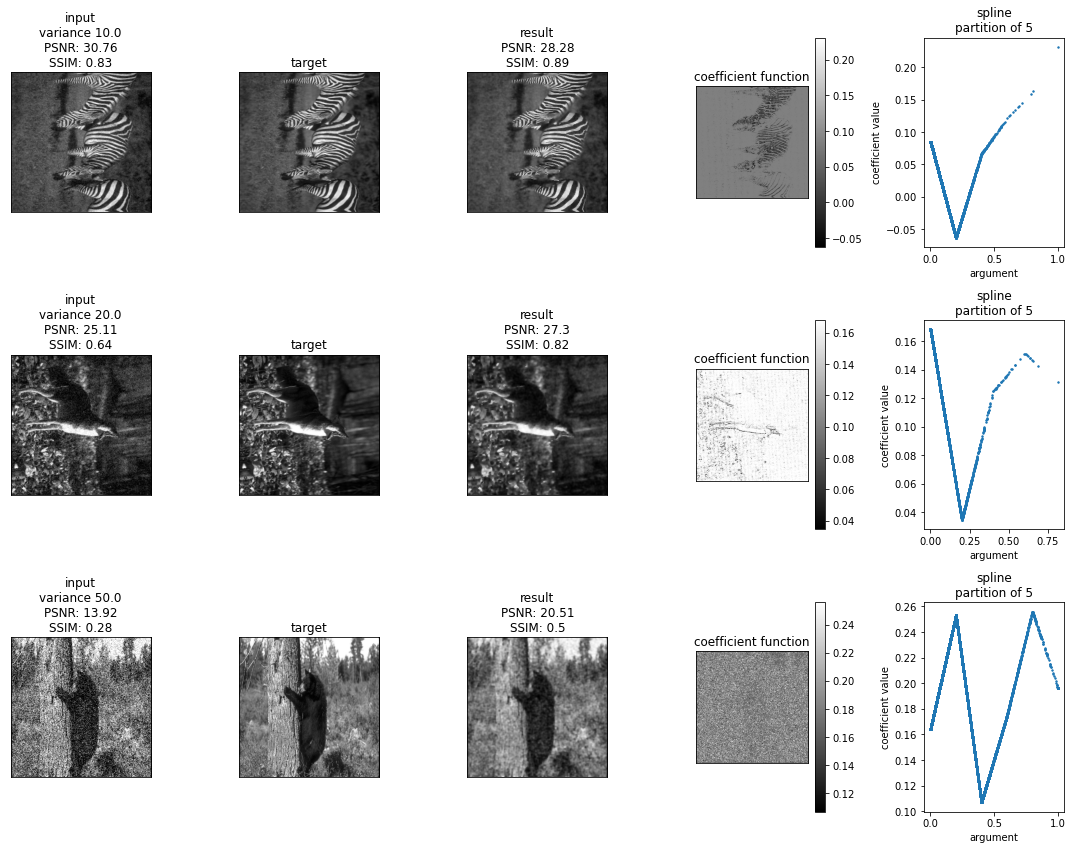

In [54]:
order = 1
num_classes = 5
model = get_model("splines",it_lim=3,image_size=image_size,num_classes=num_classes,order=order,
                         pre_smoothing=False,size=3)
model.load_weights(f"./checkpoints/splines_{typ}_{num_classes}")

w = [10,20,50]
fig,axs = plt.subplots(ncols = 5,nrows = int(np.ceil(len(w))),figsize=(15,4*len(w)))
for i,m in enumerate(w):

    
    gen_batch_train,gen_batch_val = get_generators(typ,var1_d=w[i],var1_u=w[i],CROP1=CROP,BATCH_SIZE=50)
    ims = next(gen_batch_val.as_numpy_iterator())
    p = np.clip(model(ims[0]),0,1)
    _ = np.random.choice(len(p))

    psnr_0 = tf.image.psnr(ims[0][_],ims[1][_],1).numpy()
    ssim_0 = tf.image.ssim(ims[0][_],ims[1][_],1).numpy()
    clean = p[_]
    psnr = tf.image.psnr(ims[1][_],clean,1).numpy()
    ssim = tf.image.ssim(ims[1][_],clean,1).numpy()
    clean = np.squeeze(clean)
    inputs = tf.keras.Input(shape=image_size + (1,))
    get_lambdas = tf.keras.models.Model(model.input,model.get_layer('coeff_spline').output)
    spline = np.squeeze(get_lambdas(ims[0])[_])
    visualization = tf.keras.models.Model(model.input,model.get_layer('gS_0').output)
    vis = np.squeeze(visualization(ims[0])[_])
    axx_layers = tf.keras.models.Model(model.input,model.get_layer('dx_0').output)
    axx = np.squeeze(axx_layers(ims[0])[_])


    psnr_0,ssim_0 = int(100*psnr_0)/100,int(100*ssim_0)/100
    psnr,ssim = int(100*psnr)/100,int(100*ssim)/100
    
    
    axs[i,0].imshow(ims[0][_],cmap='gray')
    axs[i,0].set_title(f'input\nvariance {int(100*m)/100}\nPSNR: {psnr_0}\nSSIM: {ssim_0}')
    axs[i,0].set_xticks([])
    axs[i,0].set_xticklabels([])
    axs[i,0].set_yticks([])
    axs[i,0].set_yticklabels([])
    axs[i,1].imshow(ims[1][_],cmap='gray')
    axs[i,1].set_title('target')
    axs[i,1].set_xticks([])
    axs[i,1].set_xticklabels([])
    axs[i,1].set_yticks([])
    axs[i,1].set_yticklabels([])
    axs[i,2].imshow(clean,cmap='gray')
    axs[i,2].set_title(f'result\nPSNR: {psnr}\nSSIM: {ssim}')
    axs[i,2].set_xticks([])
    axs[i,2].set_xticklabels([])
    axs[i,2].set_yticks([])
    axs[i,2].set_yticklabels([])
    im = axs[i,3].imshow(vis,cmap='gray')
    axs[i,3].set_title('coefficient function')
    plt.colorbar(im,ax=axs[i,3])
    axs[i,3].set_xticks([])
    axs[i,3].set_xticklabels([])
    axs[i,3].set_yticks([])
    axs[i,3].set_yticklabels([])
    

    x = np.ndarray.flatten(axx)
    s = np.ndarray.flatten(vis)
    axs[i,4].scatter(x,s,s=2)
    axs[i,4].set_xlabel("argument")
    axs[i,4].set_ylabel("coefficient value")
    axs[i,4].set_title(f"spline\npartition of {num_classes}")
    
plt.tight_layout()
plt.show()

# Comparing against Perona Malik

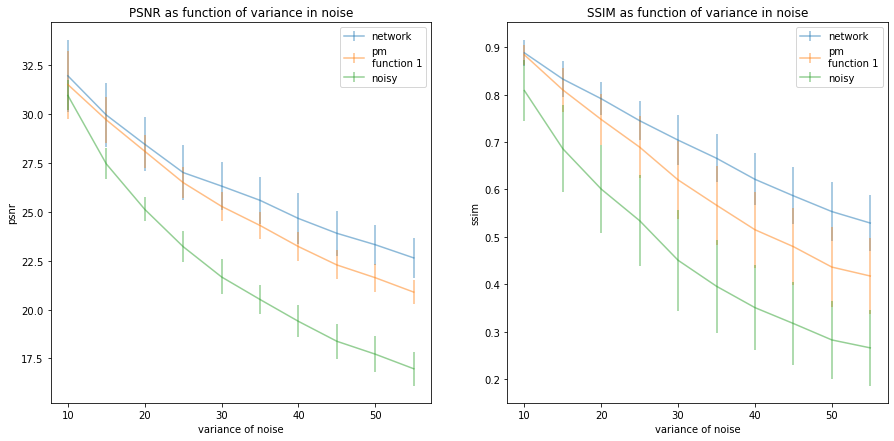

In [57]:
order = 1
num_classes = 5
model = get_model("splines",it_lim=3,image_size=image_size,num_classes=num_classes,order=order,
                         pre_smoothing=False,size=3)
model.load_weights(f"./checkpoints/splines_{typ}_{num_classes}")

w = np.linspace(10,55,10)
psnr_nn_1,psnr_nn_s_1 = [],[]
ssim_nn_1,ssim_nn_s_1 = [],[]

psnr_pm_1,psnr_pm_s_1 = [],[]
ssim_pm_1,ssim_pm_s_1 = [],[]

psnr_or_1,psnr_or_s_1 = [],[]
ssim_or_1,ssim_or_s_1 = [],[]


for i,m in enumerate(w):
    gen_batch_train,gen_batch_val = get_generators('gaussian',w[i],w[i],CROP1=CROP,BATCH_SIZE=100,
                                                  pre_smoothing=pre_smoothing,size=size,sigma=sigma)
    ims = next(gen_batch_val.as_numpy_iterator())
    
    res = model(ims[0])
    psnr = tf.image.psnr(res,ims[1],1).numpy()
    ssim = tf.image.ssim(res,ims[1],1).numpy()
    psnr_nn_1.append(np.mean(psnr))
    psnr_nn_s_1.append(np.std(psnr))
    ssim_nn_1.append(np.mean(ssim))
    ssim_nn_s_1.append(np.std(ssim))
    
    pm = np.array([anisodiff(im,niter = 3,lambd=50) for im in ims[0]])
    pm = np.asarray(pm,dtype='float32')
    psnr = [tf.image.psnr(pm[j],ims[1][j],1).numpy() for j in range(len(res))]
    ssim = [tf.image.ssim(pm[j],ims[1][j],1).numpy() for j in range(len(res))]
    psnr_pm_1.append(np.mean(psnr))
    psnr_pm_s_1.append(np.std(psnr))
    ssim_pm_1.append(np.mean(ssim))
    ssim_pm_s_1.append(np.std(ssim))
    
    psnr = tf.image.psnr(ims[0],ims[1],1).numpy()
    ssim = tf.image.ssim(ims[0],ims[1],1).numpy()
    psnr_or_1.append(np.mean(psnr))
    psnr_or_s_1.append(np.std(psnr))
    ssim_or_1.append(np.mean(ssim))
    ssim_or_s_1.append(np.std(ssim))
    
    

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.errorbar(w,psnr_nn_1,psnr_nn_s_1,label='network',alpha=0.5)
plt.errorbar(w,psnr_pm_1,psnr_pm_s_1,label='pm\nfunction 1',alpha=0.5)
plt.errorbar(w,psnr_or_1,psnr_or_s_1,label='noisy',alpha=0.5)

#plt.errorbar(w,psnr_nn_2,psnr_nn_s_2,label='network\nfunction 2',alpha=0.5)
#plt.errorbar(w,psnr_pm_2,psnr_pm_s_2,label='pm\nfunction 2',alpha=0.5)
plt.xlabel('variance of noise')
plt.ylabel('psnr')
plt.title('PSNR as function of variance in noise')
plt.legend()

plt.subplot(122)
plt.errorbar(w,ssim_nn_1,ssim_nn_s_1,label='network',alpha=0.5)
plt.errorbar(w,ssim_pm_1,ssim_pm_s_1,label='pm\nfunction 1',alpha=0.5)
plt.errorbar(w,ssim_or_1,ssim_or_s_1,label='noisy',alpha=0.5)


plt.xlabel('variance of noise')
plt.ylabel('ssim')
plt.title('SSIM as function of variance in noise')
plt.legend()
plt.show()

/tmp/ipykernel_1213407/3889189484.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ims = np.array(next(gen_batch_val.as_numpy_iterator()))
2023-02-08 18:39:53.766028: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302
2023-02-08 18:39:55.004599: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


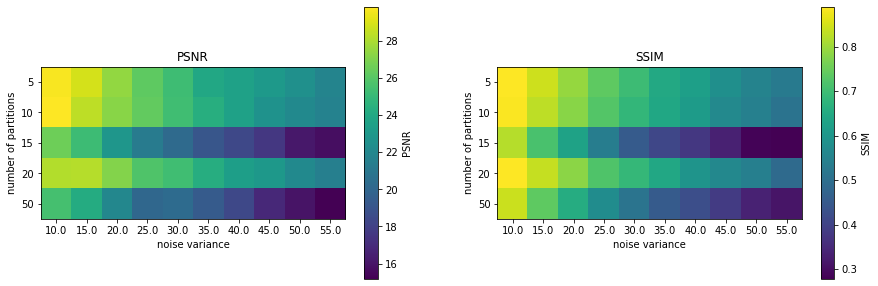

In [4]:
order = 1
w = np.linspace(10,55,10)
w = np.asarray(100*w,dtype='int')/100
ncl = np.sort([int(i.split('_')[-1].split('.')[0]) for i in glob(f"./checkpoints/splinescont2_{typ}_*.index")])


hist_psnr,hist_ssim = [],[]

for num_classes in ncl:

    psnr_nn_1,ssim_nn_1 = [],[]
    model = get_model("splines_cont",it_lim=3,image_size=image_size,num_classes = num_classes,order=order)
    for i,m in enumerate(w):
        
        model.load_weights(f"./checkpoints/splinescont2_{typ}_{num_classes}")
        gen_batch_train,gen_batch_val = get_generators(typ,0,w[i],CROP1=CROP,BATCH_SIZE=100)
        ims = np.array(next(gen_batch_val.as_numpy_iterator()))

        res = model(ims[0])
        res = res/np.expand_dims(np.expand_dims(np.amax(res,axis=(1,2)),axis=-2),axis=-2)
        psnr = [tf.image.psnr(res[j],ims[1][j],1).numpy() for j in range(len(res))]
        ssim = [tf.image.ssim(res[j],ims[1][j],1).numpy() for j in range(len(res))]
        psnr_nn_1.append(np.mean(psnr))
        ssim_nn_1.append(np.mean(ssim))


    hist_psnr.append(np.copy(psnr_nn_1))
    hist_ssim.append(np.copy(ssim_nn_1))
    

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(hist_psnr)
plt.xlabel('noise variance')
plt.ylabel('number of partitions')
plt.title('PSNR')
plt.colorbar(label='PSNR')
plt.xticks(np.arange(len(w)),w)
plt.yticks(np.arange(len(ncl)),ncl)
plt.subplot(122)
plt.imshow(hist_ssim)
plt.xlabel('noise variance')
plt.ylabel('number of partitions')
plt.title('SSIM')
plt.colorbar(label='SSIM')
plt.xticks(np.arange(len(w)),w)
plt.yticks(np.arange(len(ncl)),ncl)
plt.show()

# Analizing functions for coefficients

In [5]:
order = 1
w = np.linspace(10,60,20)
ncl = np.sort([int(i.split('_')[-1].split('.')[0]) for i in glob(f"./checkpoints/splinescont_{typ}_*.index")])
xR,R = [],[]

for num_classes in ncl:
    model = get_model("splines_cont",it_lim=1,image_size=image_size,num_classes = num_classes,order=order)
    model.load_weights(f"./checkpoints/splinescont_{typ}_{num_classes}")
    get_lambdas = tf.keras.models.Model(model.input,model.get_layer('coeff_spline').output)
    
    R.append([])
    xR.append([])
    s = []
    for i,m in enumerate(w):


        gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=w[i],CROP1=CROP,BATCH_SIZE=10)
        
        spline = []
        for it in range(10):
        
            ims = next(gen_batch_val.as_numpy_iterator())
            spl = np.squeeze(get_lambdas(ims[0]))
            for _ in range(len(spl)):
                
                x = np.linspace(0,1,1000)
                linear = np.concatenate([[spl[_][en][1] for j in range(len(x)//num_classes)] for en in range(len(spl[_]))])
                linear = np.concatenate((linear,linear[-1]*np.ones(len(x)-len(linear))))
                cte = np.concatenate([[spl[_][en][0] for j in range(len(x)//num_classes)] for en in range(len(spl[_]))])
                cte = np.concatenate((cte,cte[-1]*np.ones(len(x)-len(cte))))
                spline.append(cte + np.multiply(linear,np.mod(x,1/num_classes)))
    
    
        R[-1].append(np.copy(np.mean(spline,axis=0)))

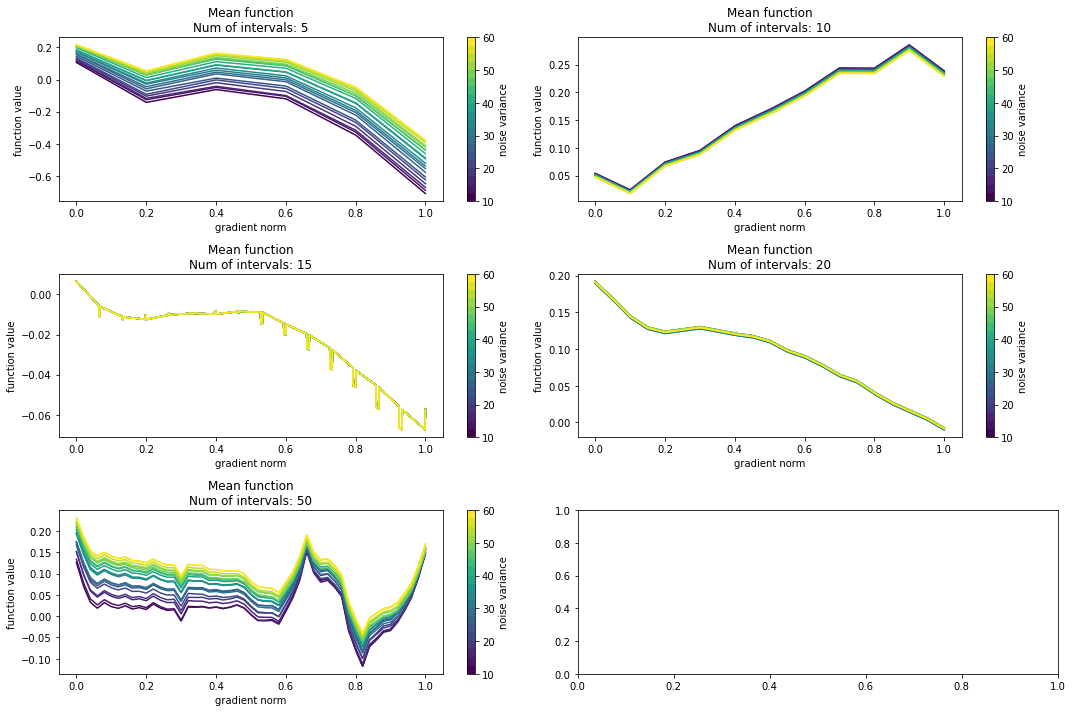

In [7]:
norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))

fig,axs = plt.subplots(ncols = 2,nrows = 3,figsize=(15,10))

for col in range(len(R)):
        
    if len(R[col]) == 0:
        continue

    viridis = cm.get_cmap('viridis', 256)
    colors = viridis(np.linspace(0, 1, len(R[col])))
    newcmp = ListedColormap(colors)

    for i in range(len(R[col])):

        #m,s = R[col][i].T

        #axs[col].errorbar(np.arange(len(m))/ncl[col],m,s,color=colors[i])
        axs[col//2,col%2].plot(np.linspace(0,1,1000),R[col][i],color=colors[i])

    axs[col//2,col%2].set_title(f"Mean function\nNum of intervals: {ncl[col]}")
    axs[col//2,col%2].set_xlabel("gradient norm")
    axs[col//2,col%2].set_ylabel("function value")
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[col//2,col%2],label='noise variance')

plt.tight_layout()        
plt.show()

# Plot the model

In [3]:
order = 1
model = get_model("splines_cont",it_lim=3,image_size=image_size,num_classes = 5,order=order)

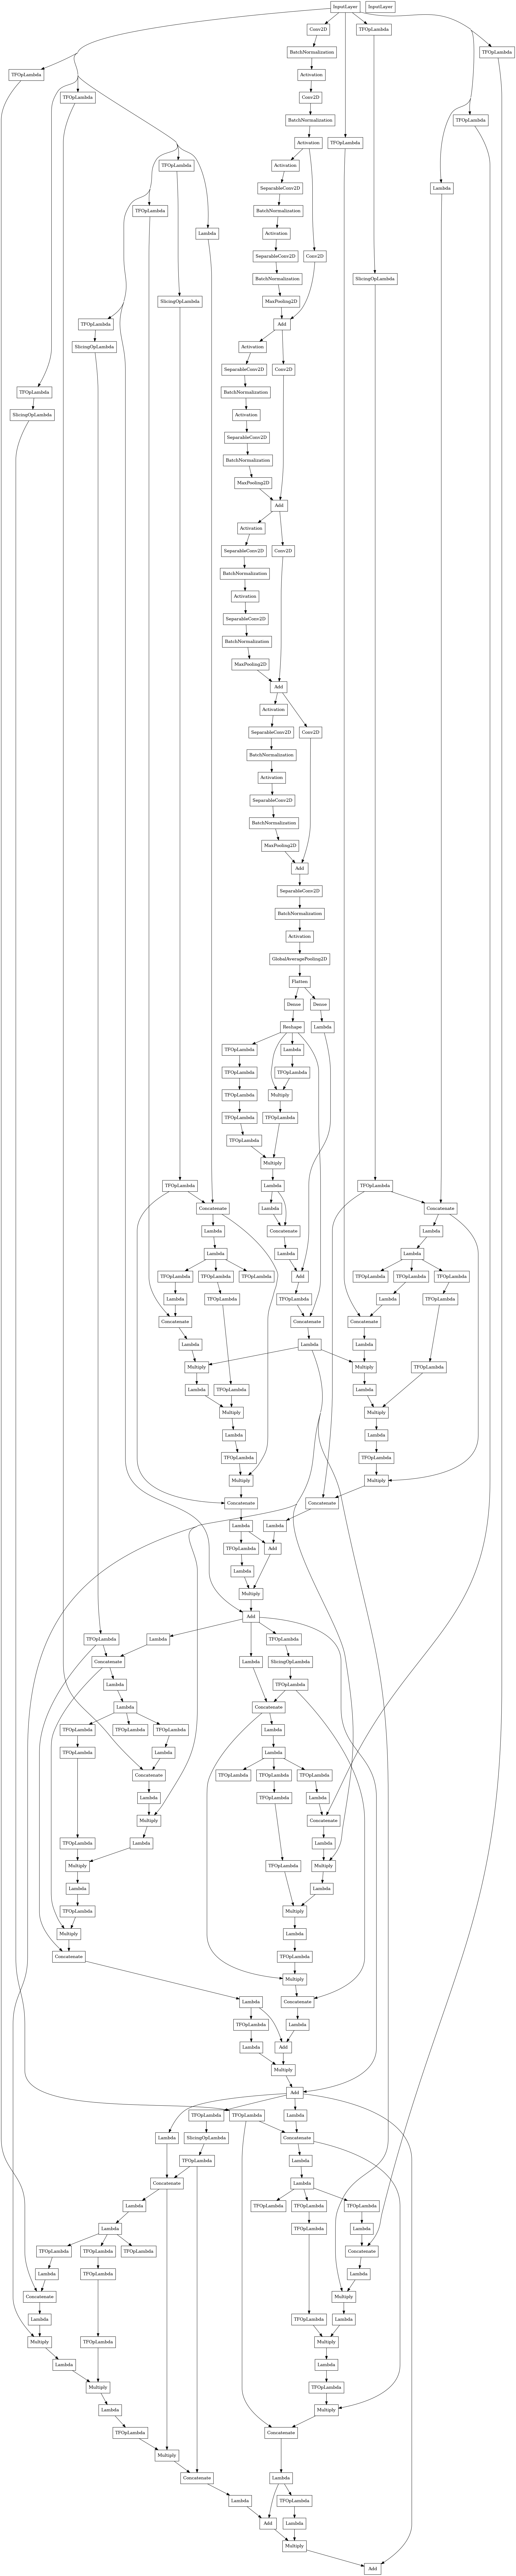

In [9]:
tf.keras.utils.plot_model(model,
    to_file="splines_cont.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,)